**Aims**

- check agreement between "review" annotation between article and publication type
- attempt to create a model to classify articles into: "Computational Method", Review, (other) "Research Article", and Others, using:
   - reviews as defined by article type and publication type
   - research article is an article with "research-article" type which is not a review nor a method
   - Computational Method are defined from manually filtered list of articles, using:
     - PubMed Central subject tags,
     - articles published in Bioinformatics (Oxford)
     - articles from awesome-multi-omics list
   - others are all other article types

In [1]:
%run notebook_setup.ipynb

In [2]:
%vault from pubmed_derived_data import literature, literature_subjects
%vault from pubmed_derived_data import publication_types as publication_types_list

Imported:

 - `literature` (904B0F94)
 - `literature_subjects` (98E10AF9)

at Saturday, 25. Jul 2020 16:33

Imported `publication_types_list` (7DD4E741) at Saturday, 25. Jul 2020 16:33

In [3]:
import pandas
pandas.set_option('display.max_colwidth', 100)

In [4]:
publication_types = (
    literature[
        'Is ' + Series(sorted(set(publication_types_list['0'])))
    ]
    .astype('object')
    .fillna(False)
    .rename(columns=lambda x: x.replace('Is ', ''))
)

### PM and PMC data

There are three variables describing the article:
 - MeSH [Publication Types](https://www.nlm.nih.gov/mesh/pubtypes.html):
   - `literature[f'Is {publication_type}']`: 1-m each article can be be assigned to multiple publication types
 - PMC-derived [article types and subjects](https://www.ncbi.nlm.nih.gov/pmc/pmcdoc/tagging-guidelines/article/dobs.html#dob-subjects):
   - `literature.article_type`: article types use controlled vocabulary; 1-1 each article has only one article type
   - `literature_subjects`: subjects are journal-specific and can describe both the content and type (sometimes are even used more like keywords/tags and include collection/conference names); 1-m

The separation between actual research articles and reviews/opinions/editorials etc is quite easy with the publication and article types; however, distinguishing novel bioinformatic methods from the biological application of existing methods is a bit more tricky.

In [5]:
publication_types.sum().sort_values(ascending=False)

Journal Article                             3370
Research Support, Non-U.S. Gov't            1371
Review                                       744
Research Support, N.I.H., Extramural         460
Research Support, U.S. Gov't, Non-P.H.S.     161
Comparative Study                             61
Editorial                                     44
Comment                                       37
Clinical Trial                                26
Published Erratum                             23
Multicenter Study                             21
Research Support, N.I.H., Intramural          16
Evaluation Study                              13
Letter                                        13
Case Reports                                   9
Dataset                                        9
Observational Study                            7
Validation Study                               7
Twin Study                                     7
Introductory Journal Article                   7
English Abstract    

In [6]:
literature.article_type.value_counts()

research-article      1566
review-article         253
brief-report            29
editorial               26
correction              17
data-paper              13
other                    8
letter                   7
article-commentary       7
product-review           5
methods-article          5
discussion               5
chapter-article          3
protocol                 2
meeting-report           2
addendum                 1
systematic-review        1
abstract                 1
Name: article_type, dtype: int64

In [7]:
literature_subjects.sum().sort_values(ascending=False).head(20)

Article                         582
Research Article                240
Review                          163
Research                        139
Genetics                        109
Original Research               100
Research Paper                   67
Biology and Life Sciences        61
Biochemistry                     53
Microbiology                     51
Genomics                         47
Computational Biology            44
Original Article                 43
Medicine and Health Sciences     42
Articles                         39
Review Article                   35
Gene Expression                  34
Genome Analysis                  31
Research Articles                30
Systems Biology                  30
dtype: int64

Excerpts from the [PMC documentation](https://www.ncbi.nlm.nih.gov/pmc/pmcdoc/tagging-guidelines/article/dobs.html#dob-subjects):
   
> Do not confuse article subjects and article types. Article subjects may be any text that identifies the content of the article (Physical Sciences, Psychology) or the type of article (Editorial, Obituary). The required article-type attribute must specify the type of article using only the values specified by PMC (see article).

> article-type - Most of the articles should have the value of "research-article". Allowed values are: "abstract", "addendum", "announcement", "article-commentary", "book-review", "books-received", "brief-report", "calendar", "case-report", "correction", "data-paper" (v2.3 must use Green), "discussion", "editorial", "expression-of-concern" (v2.3 must use Green), "in-brief", "introduction ", "letter", "meeting-report", "methods-article" (v2.3 must use Green), "news", "obituary", "oration ", "other", "product-review", "reply", "research-article", "retraction", "review-article", "systematic-review" (v2.3 must use Green).

The descriptions of the above are available [in the tagging guidelines here](https://www.ncbi.nlm.nih.gov/pmc/pmcdoc/tagging-guidelines/article/dobs.html#dob-arttype).

### Check agreement on the review type

In [8]:
is_publication_type_review = literature['Is Review'] == True
is_publication_type_review.sum()

744

In [9]:
is_article_type_review = literature['article_type'] == 'review-article'
is_article_type_review.sum()

253

In [10]:
from pandas import concat

is_review = concat([
    is_publication_type_review.rename('publication_type'),
    is_article_type_review
], axis=1)
is_review.head(3)

,publication_type,article_type
uid,,
12186644,False,False
15687693,False,False
15687700,False,False


Shared subset:

In [11]:
is_review.all(axis=1).sum()

235

#### What `article_type` do the articles with "Review" only in `publication_type` have?

In [12]:
is_review_by_publication_type_only = is_review.publication_type & ~is_review.article_type
sum(is_review_by_publication_type_only)

509

The vast majority has none - this is because article type is derived from PMC which is a subset of PM:

In [13]:
no_art_type = literature[is_review_by_publication_type_only].article_type.isnull().sum()
no_art_type, no_art_type / sum(is_review_by_publication_type_only) * 100

(423, 83.1041257367387)

But if they are annotated, those most commonly have "research article" (which is the default in PMC annotation guidelines - bias!):

In [14]:
literature[is_review_by_publication_type_only].article_type.value_counts().head(5)

research-article    78
editorial            3
brief-report         2
chapter-article      2
other                1
Name: article_type, dtype: int64

What subjects do they have?

In [15]:
literature_subjects[is_review_by_publication_type_only].sum().sort_values(ascending=False).head(5)

Article           56
Review Article     4
Paper              2
Survey             2
Metabolomics       2
dtype: int64

#### What `publication_type` do the articles with "Review" only in `article_type` have?

In [16]:
is_review_by_article_type_only = ~is_review.publication_type & is_review.article_type
sum(is_review_by_article_type_only)

18

Nothing unexpected:

In [17]:
publication_types[is_review_by_article_type_only].sum().sort_values(ascending=False).head(8)

Journal Article                             17
Research Support, Non-U.S. Gov't             4
Research Support, N.I.H., Extramural         2
Systematic Review                            1
Research Support, U.S. Gov't, Non-P.H.S.     1
News                                         1
Controlled Clinical Trial                    0
Historical Article                           0
dtype: int64

In [18]:
literature_subjects[is_review_by_article_type_only].sum().sort_values(ascending=False).head(5)

Review             4
Review Article     2
Perspective        2
Review Articles    2
Reviews            1
dtype: int64

In [19]:
literature[is_review_by_article_type_only].title

uid
22303399               When one and one gives more than two: challenges and opportunities of integrative omics.
23105932                         Perspectives of integrative cancer genomics in next generation sequencing era.
23937857                                           Idiopathic pulmonary fibrosis: the need for early diagnosis.
24910945    MOPED 2.5--an integrated multi-omics resource: multi-omics profiling expression database now inc...
24958149    Coordinating metabolite changes with our perception of plant abiotic stress responses: emerging ...
27212022                                              Multi-Omics of Single Cells: Strategies and Applications.
29301609                               Integration of metabolomics and transcriptomics in nanotoxicity studies.
29356624          From Genomics to Omics Landscapes of Parkinson's Disease: Revealing the Molecular Mechanisms.
29733683             Biobanking in a Challenging African Environment: Unique Experience from the SIR

Out of 17 above, MOPED is not a review but databased announcment. By the way, this database seems to be dead now (2020).

### Limitations of the PM and PMC data - Method Articles

While article-type "Methods Article" exists, it is rarely used and many articles which are considered as Method Articles are instead tagged as "Research Article":

In [20]:
from pandas import Series
some_method_subjects = Series(['Method Article', 'Method', 'Methodology Article', 'Research and Analysis Methods'])

In [21]:
is_research_article = literature.article_type == 'research-article'
has_method_subject = literature_subjects[some_method_subjects].any(axis=1)
research_article_tagged_as_method = (
    is_research_article
    &
    has_method_subject
)
sum(research_article_tagged_as_method)

54

In [22]:
literature[research_article_tagged_as_method].title.head(10)

uid
21619611    Identifier mapping performance for integrating transcriptomics and proteomics experimental results.
24830643         Cross-platform toxicogenomics for the prediction of non-genotoxic hepatocarcinogenesis in rat.
24884486                                    A multivariate approach to the integration of multi-omics datasets.
25137136    Integrating multi-omics for uncovering the architecture of cross-talking pathways in breast cancer.
25149441                      Using Galaxy-P to leverage RNA-Seq for the discovery of novel protein variations.
26560100    Integrative phenotyping framework (iPF): integrative clustering of multiple omics data identifie...
26626453    Fast dimension reduction and integrative clustering of multi-omics data using low-rank approxima...
26864072    Integrative modeling of multi-omics data to identify cancer drivers and infer patient-specific g...
27042856      Identification of Epigenetic Biomarkers of Lung Adenocarcinoma through Multi-Omics Dat

Even worse, many multi-omics methods are neither tagged as Method Articles nor have an appropriate subject:

In [23]:
some_method_keywords = ['method', 'workflow', 'omics approach', 'framework']

In [24]:
methods_research_articles_not_tagged_as_methods = (
    is_research_article
    &
    ~has_method_subject
    &
    literature.title.str.contains('|'.join(some_method_keywords))
)

In [25]:
literature[methods_research_articles_not_tagged_as_methods].title

uid
20090827         An integrative -omics approach to identify functional sub-networks in human colorectal cancer.
20675464       A new biodosimetric method: branched DNA-based quantitative detection of B1 DNA in mouse plasma.
20863252    Dynamics of time-lagged gene-to-metabolite networks of Escherichia coli elucidated by integrativ...
21349178    Multi-omics approach to study the growth efficiency and amino acid metabolism in Lactococcus lac...
22319563    ECOMICS: a web-based toolkit for investigating the biomolecular web in ecosystems using a trans-...
                                                           ...                                                 
31856718    Knowledge Base Commons (KBCommons) v1.1: a universal framework for multi-omics data integration ...
32170290                               Integrated multi-omics framework of the plant response to jasmonic acid.
32409713    Integrative genomics approach identifies molecular features associated with early-stage 

This can be further exemplified on the Bioinformatics publications, which are almost all methods/tools, but none of them is labeled as such:

In [26]:
in_bioinformatics = literature[literature.journal == 'Bioinformatics (Oxford, England)']
in_bioinformatics['article_type'].value_counts().head(3)

research-article     33
brief-report          2
systematic-review     0
Name: article_type, dtype: int64

In [27]:
literature_subjects.loc[in_bioinformatics.index].sum().sort_values(ascending=False).head(10)

Original Papers                          23
Systems Biology                          13
Genome Analysis                           6
Applications Notes                        6
Gene Expression                           3
Sequence Analysis                         3
Ismb/Eccb 2019 Conference Proceedings     2
Databases and Ontologies                  2
Genetics and Population Analysis          2
Systems Biology and Networks              1
dtype: int64

Yet, almost all papers publish in Bioinformatics describe a new method/tool!

In [28]:
in_bioinformatics.title

uid
17468122                                                                              GAzer: gene set analyzer.
18434345    Annotation-Modules: a tool for finding significant combinations of multisource annotations for g...
19706745                         integrOmics: an R package to unravel relationships between two omics datasets.
20529914      Integrating quantitative proteomics and metabolomics with a genome-scale metabolic network model.
21666268                                                MGV: a generic graph viewer for comparative omics data.
                                                           ...                                                 
32407457    iSOM-GSN: An Integrative Approach for Transforming Multi-omic Data into Gene Similarity Networks...
32437529    Integrating multi-OMICS data through sparse Canonical Correlation Analysis for the prediction of...
32657371    AITL: Adversarial Inductive Transfer Learning with input and output space adaptation for

### 

# Classify a subset of articles into the four classes

> Q: Can an article be both review, novel method, "research article" and other?

There are novel methods which also include original research, but goingin into full multilabel classification might be more difficult in interpretation..

## Reviews

In [29]:
review_subjects = ['Review', 'Mini-Review', 'Review Article']

I will use point-based system, adding:
  - 1 point for `publication_type == 'Review'`, 0 otherwise
  - 1 point for `article_type == 'review-article'`, 0 otherwise
  - 1 point for `subject in review_subjects`

<s>Which will be turned into following pseudo-probabilities:</s>
  - 1 (certainly a review) for 2 or more points (i.e. for having at least two confirmation sources)
  - 0.5 (maybe a review) for 1 point
  - 0 (not a review) for 0 points
  
> Q: Why not to use 1/3, 2/3 and 3/3 as the pseudo-probabilities?

<s>Because the `subject` and `article_type` are not independent! Both are entered into the PMC by the submitter who is likely to choose `article_type` based on the `subjects`.</s>

For simplicity, for now using a simpler but less powerful "any" criterion - does any source mention that this is a review?

> Q: should systematic reviews be included as well?

Maybe. My hypothesis is that there are quite many reviews obstructing the overview analysis (i.e. mentioning various omics terms but - obviously - not actually using them; some omics may be popular in reviews, but actually difficult to integrate and therefore rarely used in the actual research!). Given this hypothesis, systematic reviews are not the type of reviews I am interested in (to single out).

> Q: could we use Bayesian inference?

Maybe. The information on missingness could be also utilized, as well as title features (i.e. whether "review" is mentioned in the title) but this is outside of scope of this analysis.

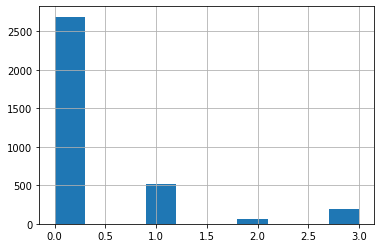

In [30]:
review_score = (
    publication_types['Review'].astype(int)
    +
    (literature.article_type == 'review-article').astype(int)
    +
    literature_subjects[review_subjects].any(axis=1).astype(int)
)
review_score.hist();

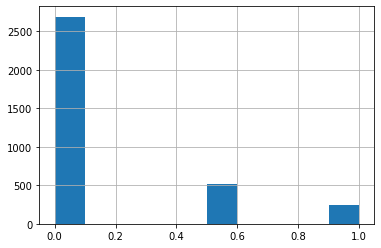

In [31]:
review_pseudo_probability = review_score.map({3: 1, 2: 1, 1: 0.5, 0: 0})
review_pseudo_probability.hist();

In [32]:
sum(review_pseudo_probability == 1)

245

## Computational methods

Methods are assembled from:
   - manually filtered list of articles narrowing down from articles with subject "Method", "Method Article", "Methodology"
   - methods from awesome-multi-omics list (i.e. excluding reviews, conferences etc)
   - manually filtered list or articles published in Bioinformatics (Oxford)

By Computational Method I mean any of the following:
  - a novel algorithm, statistical method or framework
  - a re-implementation of a framework/tool with existing algorithms even with only minor improvements over predecessors
  - a web-server providing capability to run statistical analysis - whether novel or not

Excluding:
  - research papers whose main contribution is application of a method (whether recent/advanced or not) to a novel dataset, e.g.:
     - ["Computationally expanding infinium HumanMethylation450 BeadChip array data to reveal distinct DNA methylation patterns of rheumatoid arthritis."](https://doi.org/10.1093/bioinformatics/btw089)
     - ["Global proteomics profiling improves drug sensitivity prediction: results from a multi-omics, pan-cancer modeling approach."](https://doi.org/10.1093/bioinformatics/btx766)
     - ["Multi-omics reveals functional genomic and metabolic mechanisms of milk production and quality in dairy cows."](https://doi.org/10.1093/bioinformatics/btz951)
  - web-servers providing database functionality only (without data analysis, not counting simple annotation)

In [33]:
from pandas import read_csv


def prepare_for_manual_annotation(data):
    return (
        data[['title']]
        .assign(
            link='https://doi.org/' + data.doi,
            is_comp_method='',
            # is a package implementing a computational algorithm(s)?
            is_tool='',
            # is database/annotation helper tool (not database itself)
            is_annotation_tool='',
            is_database='',
            # is application of multi-omic methods to a novel reasearch
            is_application='',
            # is a study dedicated to benchmarking?
            is_benchmark='',
            # has at least one comparison to other methods?
            has_comparisons='',
            comment=''
        )
    )


def annotated_as_method_or_tool(annotations):
    return (
        (annotations.set_index('uid').reindex(literature.index)[['is_comp_method', 'is_tool']] == 'y')
        .any(axis=1)
    )

def check_annotations(annotations, reference):
    if set(annotations.title) != set(reference.title):
        a = set(annotations.title)
        r = set(reference.title)
        raise ValueError(f'{a - r} missing, {r - a} too much')
    assert set(annotations.uid) == set(reference.index)
    for column in ['is_comp_method', 'is_tool', 'is_annotation_tool', 'is_database', 'is_application', 'is_benchmark', 'has_comparisons']:
        assert set(annotations[column].dropna()) - {'y'} == set()


methods_annotations = Path('manual_curation/computational_methods')

### Methods from subjects

In [34]:
def find_subjects(regexp):
    counts = literature_subjects.sum().sort_values(ascending=False)
    return counts.loc[counts.index.str.lower().str.contains(regexp)]

In [35]:
method_subjects_counts = find_subjects('method')
method_subjects_counts

Research and Analysis Methods       24
Methodology Article                 19
Method                              13
Methods                             11
Methodology                         10
Database and Informatics Methods     8
Statistical Methods                  5
Research and analysis methods        4
Methods and Resources                2
Methods Online                       2
Methods and Protocols                1
Experimental Biophysical Methods     1
Method Article                       1
dtype: int64

In [36]:
ignored_method_subjects = {'Experimental Biophysical Methods'}
assert ignored_method_subjects - set(method_subjects_counts.index) == set()

In [37]:
method_subjects = sorted(set(method_subjects_counts.index) - ignored_method_subjects)
method_subjects

['Database and Informatics Methods',
 'Method',
 'Method Article',
 'Methodology',
 'Methodology Article',
 'Methods',
 'Methods Online',
 'Methods and Protocols',
 'Methods and Resources',
 'Research and Analysis Methods',
 'Research and analysis methods',
 'Statistical Methods']

In [38]:
has_method_subject = literature_subjects[method_subjects].any(axis=1)
sum(has_method_subject)

81

In [39]:
candidates_articles_for_methods = literature[has_method_subject]
candidates_articles_for_methods.journal.value_counts().head(10)

PloS one                      17
BMC bioinformatics            16
Genome biology                 9
PLoS computational biology     4
BMC genomics                   4
Genome research                3
Frontiers in microbiology      2
Nucleic acids research         2
Cancer informatics             2
Frontiers in genetics          2
Name: journal, dtype: int64

Note: No _Bionformatics (Oxford, UK)_ articles tagged as a method!

In [40]:
(
    prepare_for_manual_annotation(candidates_articles_for_methods)
    .to_csv(methods_annotations / 'subjects-blank.csv')
)

In [41]:
annotation_for_subjects = read_csv(methods_annotations / 'subjects-annotated.csv')
check_annotations(annotation_for_subjects, candidates_articles_for_methods)

In [42]:
(annotation_for_subjects.is_comp_method == 'y').mean(), (annotation_for_subjects.is_tool == 'y').mean()

(0.5432098765432098, 0.08641975308641975)

In [43]:
is_method_for_subjects = annotated_as_method_or_tool(annotation_for_subjects)

### Methods from awesome-multi-omics

In [44]:
from pathlib import Path
from helpers.awesome import get_between_headers, extract_references

amo_software_and_methods_header = '## Software packages and methods'
amo_reviews_header = '## Multi-omics reviews / evaluations'
amo_applications_header = '## Multi-omics application papers'
amo_data_header = '## Multi-omics data management'

community_curated_list = (
    Path('data/awesome-multi-omics-README.md')
    .read_text().splitlines()
)

amo_methods = get_between_headers(
    community_curated_list,
    start=amo_software_and_methods_header, end=amo_reviews_header
)
len(amo_methods)

97

In [45]:
amo_methods_references = extract_references(amo_methods)
{k: len(v) for k, v in amo_methods_references.items()}

{'doi': 41, 'pubmed': 6, 'pubmed_central': 17}

In [46]:
amo_dois = Series(amo_methods_references['doi'])
bioarchive_dois = amo_dois[amo_dois.str.startswith('10.1101')]
bioarchive_dois

13               10.1101/046904
20               10.1101/519207
38    10.1101/2020.04.01.020685
39               10.1101/344309
dtype: object

In [47]:
not_yet_published = {
    '10.1101/519207'
}

preprint_to_final_publication = {
    '10.1101/046904': '10.1074/mcp.TIR118.001251',
    '10.1101/2020.04.01.020685': '10.3389/fonc.2020.01065',
    '10.1101/344309': '10.1186/s13059-019-1645-z'
}

assert set(bioarchive_dois) == set(preprint_to_final_publication) | not_yet_published

amo_methods_references['doi'] = [
    preprint_to_final_publication[doi] if doi in preprint_to_final_publication else doi
    for doi in amo_methods_references['doi']
]

In [48]:
from pandas import DataFrame

def is_referenced(references, literature):
    matches = DataFrame({
        'doi': literature['doi'].isin(references['doi']),
        'pubmed_central': literature['PMC'].isin(references['pubmed_central']),
        'pubmed': literature.index.isin({int(p) for p in references['pubmed']})
    })
    print(matches.any())

    return matches.any(axis=1)

In [49]:
is_referenced_in_amo_as_method = is_referenced(amo_methods_references, literature)
sum(is_referenced_in_amo_as_method)

doi                True
pubmed_central     True
pubmed            False
dtype: bool


10

In [50]:
literature[is_referenced_in_amo_as_method].title

uid
24884486                                    A multivariate approach to the integration of multi-omics datasets.
27716030    Handling missing rows in multi-omics data integration: multiple imputation in multiple factor an...
29925568         Multi-Omics Factor Analysis-a framework for unsupervised integration of multi-omics data sets.
30657866         DIABLO: an integrative approach for identifying key molecular drivers from multi-omics assays.
30957844                                     Unsupervised discovery of phenotype-specific multi-omics networks.
31243065                             MOGSA: Integrative Single Sample Gene-set Analysis of Multiple Omics Data.
31501851                       Spectrum: fast density-aware spectral clustering for single and multi-omic data.
31792061                           Evaluation of colorectal cancer subtypes and cell lines using deep learning.
31918677          Multiset sparse partial least squares path modeling for high dimensional omics dat

In [51]:
amo_reviews = get_between_headers(community_curated_list, amo_reviews_header, amo_applications_header)
len(amo_reviews)

25

In [52]:
sum(is_referenced_in_amo_as_method & has_method_subject)

5

### Methods from from Bioinformatics journal

In [53]:
(
    prepare_for_manual_annotation(in_bioinformatics)
    .to_csv(methods_annotations / 'bioinformatics_journal-blank.csv')
)

Note: has_comparisons column not finished for this annotations set.

In [54]:
annotation_for_bioinformatics = read_csv(methods_annotations / 'bioinformatics_journal-annotated.csv')
check_annotations(annotation_for_bioinformatics, in_bioinformatics)

In [55]:
(annotation_for_bioinformatics.is_comp_method == 'y').mean(), (annotation_for_bioinformatics.is_tool == 'y').mean()

(0.6323529411764706, 0.3235294117647059)

In [56]:
is_method_in_bioinformatics_journal = annotated_as_method_or_tool(annotation_for_bioinformatics)

In [57]:
is_method = (
    is_method_for_subjects
    |
    is_referenced_in_amo_as_method
    |
    is_method_in_bioinformatics_journal
)

In [58]:
sum(is_method)

115

### Research articles

In [59]:
literature_subjects.sum().sort_values().tail(20)

Systems Biology                  30
Research Articles                30
Genome Analysis                  31
Gene Expression                  34
Review Article                   35
Articles                         39
Medicine and Health Sciences     42
Original Article                 43
Computational Biology            44
Genomics                         47
Microbiology                     51
Biochemistry                     53
Biology and Life Sciences        61
Research Paper                   67
Original Research               100
Genetics                        109
Research                        139
Review                          163
Research Article                240
Article                         582
dtype: int64

In [60]:
has_research_article_subject = literature_subjects[['Research Article', 'Original Research', 'Research Paper', 'Research', 'Research Articles']].any(axis=1)
sum(has_research_article_subject)

558

In [61]:
is_article_type_research = literature.article_type == 'research-article'
sum(is_article_type_research)

1566

The agreement is high:

In [62]:
sum(has_research_article_subject & is_article_type_research)

556

In [63]:
is_certainly_review = review_pseudo_probability == 1

In [64]:
is_other_research_article = (
    (has_research_article_subject | is_article_type_research)
    &
    (~is_method)
    &
    (~is_certainly_review)
)
sum(is_other_research_article)

1484

### Other

Other are all articles which are not any of the above.

### Final dataset

In [65]:
all_labels = literature.index.to_frame().drop(columns='uid').copy()
all_labels['is_review'] = review_pseudo_probability
all_labels['is_method'] = is_method
all_labels['is_other_research_article'] = is_other_research_article
all_labels['is_other'] = ~all_labels.any(axis=1)

For training I will only use the subset of articles that have:
 - both:
   - at least one publication type, AND
   - either article_type or subject
 - or:
   - are labeled as methods (which are manually curated)

In [66]:
has_any_publication_type = publication_types.any(axis=1)
has_any_publication_type.mean()

0.9991319444444444

In [67]:
has_article_type = ~literature.article_type.isnull()
has_article_type.mean()

0.5645254629629629

In [68]:
has_any_subject = literature_subjects.any(axis=1)
has_any_subject.mean()

0.5645254629629629

In [69]:
assert all(has_any_subject == has_article_type)

In [70]:
is_qualifying_article = (has_any_publication_type & has_article_type) | all_labels.is_method
sum(is_qualifying_article)

1982

In [71]:
labels = all_labels[is_qualifying_article]
labels.head(5)

,is_review,is_method,is_other_research_article,is_other
uid,,,,
12186644,0.0,False,False,True
16611894,0.0,False,True,False
17420480,0.0,False,True,False
17449607,0.0,False,True,False
17468122,0.0,True,False,False


In [72]:
(~(labels == False)).sum()

is_review                     341
is_method                     115
is_other_research_article    1484
is_other                      118
dtype: int64

In [73]:
%vault store labels as reliable_article_types in pubmed_derived_data

Stored `labels` (5D584CB5 → 5D584CB5) at Saturday, 25. Jul 2020 16:34

# Create features for to infer the types of the remaining articles

In [74]:
%vault import code_repositories from pubmed_derived_data

Imported `code_repositories` (5FF4AA2D) at Saturday, 25. Jul 2020 16:34

In [75]:
from repository_detection import source_code_platforms, mixed_publication_platforms

In [76]:
code_respository_or_package_link = Series([
    *source_code_platforms,
    *mixed_publication_platforms
])

In [77]:
any_code_or_package_link = (code_repositories['abstract_' + code_respository_or_package_link + '_matches'] != '[]').any(axis=1)
sum(any_code_or_package_link)

72

In [78]:
code_links_from_abstracts = code_repositories['abstract_' + code_respository_or_package_link + '_matches'] != '[]'
code_links_from_abstracts['any_code_or_package_link'] = any_code_or_package_link

In [79]:
#%vault import omics_features from pubmed_derived_data

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.3,
    ngram_range=(1, 3),
    max_features=5000,
    min_df=2,
    stop_words='english',
    use_idf=True
)

In [81]:
X = vectorizer.fit_transform(literature['title'] + ' ' + literature['abstract_clean'].fillna(''))

In [82]:
dataset = literature[is_qualifying_article]

In [83]:
words = DataFrame(
    X.todense(),
    columns=vectorizer.get_feature_names(),
    index=literature.index
)

In [84]:
words.columns

Index(['000', '001', '01', '05', '10', '100', '1000', '11', '12', '13',
       ...
       'yeast', 'yield', 'yielded', 'yields', 'young', 'zebrafish', 'zinc',
       'zone', 'μg', 'μm'],
      dtype='object', length=5000)

In [85]:
# the problem with omcis features is that those use full text, so that would note be great for prediction of non-PMC articles
# .join(omics_features)

In [86]:
from sklearn.preprocessing import OneHotEncoder

In [87]:
journal_encoder = OneHotEncoder()
journals = DataFrame(
    journal_encoder.fit_transform(literature[['journal']].fillna('-')).todense(),
    columns=journal_encoder.get_feature_names(),
    index=literature.index
)

In [88]:
journals.head()

,x0_-,"x0_ACM-BCB ... ... : the ... ACM Conference on Bioinformatics, Computational Biology and Biomedicine. ACM Conference on Bioinformatics, Computational Biology and Biomedicine",x0_ACS applied materials & interfaces,x0_ACS chemical biology,x0_ACS chemical neuroscience,x0_ACS infectious diseases,x0_ACS omega,x0_ACS sensors,x0_ACS synthetic biology,x0_AIMS neuroscience,...,x0_Zhonghua liu xing bing xue za zhi = Zhonghua liuxingbingxue zazhi,x0_Zhonghua nan ke xue = National journal of andrology,x0_Zhonghua yi xue za zhi,x0_Zhonghua yu fang yi xue za zhi [Chinese journal of preventive medicine],"x0_Zoology (Jena, Germany)",x0_eLife,x0_iScience,x0_mBio,x0_mSphere,x0_mSystems
uid,,,,,,,,,,,,,,,,,,,,,
12186644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15687693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15687700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15687839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15763567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
all_features = (
    words
    .join(code_links_from_abstracts)
    .join(
        # removing bionformatics, as it was used to select methods
        # - we are likely to have overrepresentation of articles from there!
        journals.drop(columns=['x0_Bioinformatics (Oxford, England)'])
    )
)

In [90]:
all_features.head()

,000,001,01,05,10,100,1000,11,12,13,...,x0_Zhonghua liu xing bing xue za zhi = Zhonghua liuxingbingxue zazhi,x0_Zhonghua nan ke xue = National journal of andrology,x0_Zhonghua yi xue za zhi,x0_Zhonghua yu fang yi xue za zhi [Chinese journal of preventive medicine],"x0_Zoology (Jena, Germany)",x0_eLife,x0_iScience,x0_mBio,x0_mSphere,x0_mSystems
uid,,,,,,,,,,,,,,,,,,,,,
12186644,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15687693,0.08517,0.0,0.0,0.0,0.0,0.085646,0.0,0.0,0.0,0.084032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15687700,0.00000,0.0,0.0,0.0,0.0,0.073428,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15687839,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15763567,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
features = all_features[is_qualifying_article]

## Train-test split

In [92]:
assert len(features) == len(labels)

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
X_train, X_test, y_train, y_test = train_test_split(features, labels)

## Train & test

In [95]:
from sklearn.linear_model import LogisticRegressionCV   # could do LinearSVC...
from sklearn import metrics

In [96]:
models = {}
coefficients = []

for label in y_train:
    lr = LogisticRegressionCV(penalty='l1', solver='liblinear', scoring='balanced_accuracy')
    lr.fit(X_train, y_train[label] > 0)
    coeffs = Series(
        lr.coef_[0],
        index=features.columns
    ).sort_values()
    
    coefficients.append({
        'coeffs': coeffs[coeffs != 0],
        'label': label,
        'balanced_accuracy': lr.score(X_test, y_test[label] > 0),
        'f1': metrics.f1_score(y_test[label] > 0, lr.predict(X_test)),
        'classification_report': metrics.classification_report(y_test[label] > 0, lr.predict(X_test))
    })
    models[label] = lr

In [97]:
coefficients = DataFrame(coefficients)
coefficients

,coeffs,label,balanced_accuracy,f1,classification_report
0,multi view -30.016092 x0_BMJ open -25.392325 x0_E...,is_review,0.840775,0.765027,precision recall f1-score support\n\n False 0.93 0.96 ...
1,experiments -35.066578 levels -31.910949 review ...,is_method,0.772629,0.620690,precision recall f1-score support\n\n False 0.97 0.98 ...
2,biological networks -49.225598 current -47.980357 review -45.3819...,is_other_research_article,0.782313,0.882108,precision recall f1-score support\n\n False 0.69 0.68 ...
3,potential -31.555880 role -29.241451 genetic -27.469572 recent -25...,is_other,0.681720,0.444444,precision recall f1-score support\n\n False 0.96 0.98 ...


In [98]:
print(coefficients.classification_report.iloc[1])

              precision    recall  f1-score   support

       False       0.97      0.98      0.98       464
        True       0.69      0.56      0.62        32

    accuracy                           0.96       496
   macro avg       0.83      0.77      0.80       496
weighted avg       0.95      0.96      0.95       496



In [99]:
coefficients.coeffs.iloc[0]

multi view                         -30.016092
x0_BMJ open                        -25.392325
x0_Expert review of proteomics     -21.731010
x0_Journal of clinical genomics    -20.872391
published                          -18.235762
                                      ...    
current                             41.009559
recent                              47.454908
issues                              49.361333
past                                51.945478
review                             119.089107
Length: 327, dtype: float64

In [100]:
coefficients.coeffs.iloc[1]

experiments                    -35.066578
levels                         -31.910949
review                         -28.445088
identified                     -26.372249
patients                       -25.175744
                                  ...    
rank                            30.192395
supplementary data available    32.662197
dimensionality                  33.615021
available bioinformatics        39.975888
simulated                       42.476170
Length: 473, dtype: float64

In [101]:
coefficients.coeffs.iloc[2]

biological networks   -49.225598
current               -47.980357
review                -45.381959
multiple layers       -36.233451
settings              -34.522888
                         ...    
demonstrated           33.174705
program                35.600166
perform                35.801292
identified             37.146642
classes                37.217212
Length: 1160, dtype: float64

In [102]:
# literature.loc[X_test.index].assign(prediction=models['is_review'].predict(X_test))[['title', 'prediction']].sort_values('prediction')

## Predict

In [114]:
is_qualifying_article.mean()

0.5734953703703703

In [103]:
input_data = all_features[~is_qualifying_article]
predictions = input_data.index.to_frame().drop(columns='uid')

for label, model in models.items():
    predictions[label] = model.predict(input_data)

In [104]:
predictions.join(literature)[['title', *predictions.columns]]

,title,is_review,is_method,is_other_research_article,is_other
uid,,,,,
15687693,Integromic analysis of the NCI-60 cancer cell lines.,False,False,False,False
15687700,"Genetic, genomic, and bioinformatic tools for studying breast cancer progression.",False,False,True,False
15687839,"Genomics, proteomics and integrative ""omics"" in hypertension research.",True,False,False,False
15763567,An integrated approach for inference and mechanistic modeling for advancing drug development.,False,False,False,False
16077939,Comparative genomics on SFRP1 orthologs.,False,False,True,False
...,...,...,...,...,...
32697738,SMSPL: Robust Multimodal Approach to Integrative Analysis of Multiomics Data.,False,False,False,False
32698759,Multi-omics sequencing provides insight into floral transition in Catalpa bungei. C.A. Mey.,False,False,True,False
32698873,Multiomics global landscape of stemness-related gene clusters in adipose-derived mesenchymal ste...,False,False,True,False


In [105]:
%vault store predictions as predicted_article_types in pubmed_derived_data

Stored `predictions` (None → 3D39430E) at Saturday, 25. Jul 2020 16:34

Are the review predictions comparable to articles marked as review (without supporting evidence - so not in train/test)?

In [106]:
is_review_left_aside = all_labels[~is_qualifying_article].is_review > 0

In [107]:
len(is_review_left_aside)

1474

In [108]:
sum(is_review_left_aside == predictions.is_review), sum(is_review_left_aside != predictions.is_review)

(1215, 259)

In [109]:
reviews_left_aside = set(is_review_left_aside[is_review_left_aside].index)
reviews_from_pred = set(predictions[predictions.is_review].index)

In [110]:
len(reviews_left_aside & reviews_from_pred), len(reviews_left_aside | reviews_from_pred)

(256, 515)

In [111]:
len(reviews_left_aside - reviews_from_pred)

167

In [112]:
len(reviews_from_pred - reviews_left_aside)

92

Well, the overlap is larger than the difference...